<a href="https://colab.research.google.com/github/stanfordstuckey/VeryFirstRepos/blob/main/feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 4: Feature Engineering with Clinical Data [120 points]

### BIOMEDIN 215 (Data Driven Medicine), Fall 2021 

### Due: Tuesday, October 26th, 2021


In this assignment you will gain experience transforming clinical data into sets of features for downstream statistical analysis. You will practice using common time-saving tools in the R programming language that are ideally suited to these tasks.

You will primarily be building off of the cohort that you developed in the Cohort Building homework. In particular, you will extract features from vitals, diagnosis codes, and more that can be used to predict the future development of septic shock. 

You will not be replicating the models presented in ["A targeted real-time early warning score (TREWScore) for septic shock" by Henry et al.](http://stm.sciencemag.org/content/7/299/299ra122.full) directly, but we include a link to the paper for your reference.

All of the data you need for this assignment is available on Canvas.

Please edit this document directly using either Jupyter or R markdown in RStudio and answer each of the questions in-line. Turn in a single .pdf document showing all of your code and output for the entire assignment, with each question clearly demarcated. Submit your completed assignment through Canvas.

## 0. Getting Ready

The first thing we need to do is load all of the packages we will use for this assignment. Please load the packages `tidyverse`, `lubridate`, `data.table`, `Matrix`, and `glmnet`. Also, please run the command `Sys.setenv(TZ='UTC')`.

In [ ]:
install.packages("tidyverse")
install.packages("lubridate")
install.packages("data.table")
install.packages("Matrix")
install.packages("glmnet")

Sys.setenv(TZ='UTC')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’




In [1]:
library(tidyverse)
library(lubridate)
library(data.table)
library(Matrix)
library(glmnet)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘Matrix’


The following object

ERROR: ignored

In [2]:
Sys.setenv(TZ='UTC')

## 1. Defining labels for prediction

-----
##### 1.1 (10 pts)

We are going to take the 1000 subject development cohort you worked with on the previous assignment and explore some methods of feature engineering for the task of predicting whether a patient will go on to develop septic shock. You will start with a dataset similar to what you might have generated at the end of the prior assignment. This dataset is available in the file `cohort_labels.csv`.

The prediction problem motivating this assignment is to predict, at 12 hours into an admission, whether septic shock will occur during the remainder of the admission, with at least 3 hours of lead time. Your task is to engineer a set of features that may be used as the inputs to a model that makes this prediction.

We will derive the **labels** and **index times** in a way that aligns with the task description above. Note that this is not the same procedure as in the TREWscore paper.

We will use the following definitions:

* We will only assign labels to admissions of at least twelve hours in duration.
* An admission is assigned a negative label if septic shock does not occur at any time during the admission.
* An admission is assigned a positive label if septic shock occurs fifteen hours after admission or later.
* Admissions where the earliest time of septic shock occurs prior to fifteen hours after admission are removed from the study.
* For admissions that have valid labels, we assign an index time at twelve hours into the admission. For prediction, we only use information that occurs before the index time.
* In the case that a patient has multiple admissions for which a valid index time and label may be assigned, we only use the latest one.

To begin, given the above definitions, load `cohort_labels.csv` and `ADMISSIONS.csv` and derive the binary classification labels for septic shock and the corresponding index times for each patient in the dataframe. The result should be a dataframe with one row per patient and additional columns for `index_time` and `label`.

How many patients receive a positive or negative label?

----

In [4]:
library(readr)
ADMISSIONS <- read_csv("/content/ADMISSIONS.csv")

Rows: 58976 Columns: 19

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): ADMISSION_TYPE, ADMISSION_LOCATION, DISCHARGE_LOCATION, INSURANCE,...
dbl  (5): ROW_ID, SUBJECT_ID, HADM_ID, HOSPITAL_EXPIRE_FLAG, HAS_CHARTEVENTS...
dttm (5): ADMITTIME, DISCHTIME, DEATHTIME, EDREGTIME, EDOUTTIME


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [5]:
cohort_labels <- read_csv("/content/cohort_labels.csv")

Rows: 247936 Columns: 7

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (3): subject_id, hadm_id, icustay_id
lgl  (3): sepsis, severe_sepsis, septic_shock
dttm (1): charttime


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



So to begin I created a copy of the `ADMISSIONS` df, which I called `twelvehour_more`. Basically here all I am doing is calculating the time difference between admit and discharge into a new column which will display the total time in hours they were in the hospital. 

In [6]:
hour_in_hosp <- ADMISSIONS
hour_in_hosp$time_diff <- difftime(hour_in_hosp$DISCHTIME, hour_in_hosp$ADMITTIME, units = c("hours"))
head(hour_in_hosp)

ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,time_diff
<dbl>,<dbl>,<dbl>,<dttm>,<dttm>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dttm>,<dttm>,<chr>,<dbl>,<dbl>,<drtn>
21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NA,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NA,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,27.46667 hours
22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NA,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NA,CATHOLIC,MARRIED,WHITE,NA,NA,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT/SDA,0,1,131.91667 hours
23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NA,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NA,NA,BRAIN MASS,0,1,162.43333 hours
24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NA,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NA,PROTESTANT QUAKER,SINGLE,WHITE,NA,NA,INTERIOR MYOCARDIAL INFARCTION,0,1,68.56667 hours
25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NA,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NA,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,84.81667 hours
26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NA,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,NA,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NA,NA,V-TACH,0,1,167.73333 hours


Now, I am going to look through the `DIAGNOSIS` column and assign a positive label to all cases that have a diagnosis that contains the string 'SEPSIS'. I am also going to be copying my df's into one master dataframe I will us from here on:

In [7]:
Septic_Pts <- hour_in_hosp
Septic_Pts$Sep_diag_TF <- grepl('SEPSIS', Septic_Pts$DIAGNOSIS)
Septic_Pts$Sepsis_diag <- ifelse(Septic_Pts$Sep_diag_TF == 'TRUE', 'Positive', 'Negative')
head(Septic_Pts)

ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,⋯,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,time_diff,Sep_diag_TF,Sepsis_diag
<dbl>,<dbl>,<dbl>,<dttm>,<dttm>,<dttm>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dttm>,<dttm>,<chr>,<dbl>,<dbl>,<drtn>,<lgl>,<chr>
21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NA,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,⋯,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,27.46667 hours,FALSE,Negative
22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NA,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,⋯,MARRIED,WHITE,NA,NA,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT/SDA,0,1,131.91667 hours,FALSE,Negative
23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NA,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,⋯,MARRIED,WHITE,NA,NA,BRAIN MASS,0,1,162.43333 hours,FALSE,Negative
24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NA,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,⋯,SINGLE,WHITE,NA,NA,INTERIOR MYOCARDIAL INFARCTION,0,1,68.56667 hours,FALSE,Negative
25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NA,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,⋯,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,84.81667 hours,FALSE,Negative
26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NA,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,⋯,SINGLE,UNKNOWN/NOT SPECIFIED,NA,NA,V-TACH,0,1,167.73333 hours,FALSE,Negative


Now I will add the index_time column to the dataframe via adding 12 hours to the `ADMISSION` time using lubridate:

In [8]:
Septic_Pts$index_time <- Septic_Pts$ADMITTIME + hours(12)
names(Septic_Pts)[22] <- 'label'
head(Septic_Pts)

ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,⋯,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,time_diff,Sep_diag_TF,label,index_time
<dbl>,<dbl>,<dbl>,<dttm>,<dttm>,<dttm>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<dttm>,<dttm>,<chr>,<dbl>,<dbl>,<drtn>,<lgl>,<chr>,<dttm>
21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NA,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,⋯,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,27.46667 hours,FALSE,Negative,2196-04-10 00:26:00
22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NA,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,⋯,WHITE,NA,NA,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT/SDA,0,1,131.91667 hours,FALSE,Negative,2153-09-03 19:15:00
23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NA,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,⋯,WHITE,NA,NA,BRAIN MASS,0,1,162.43333 hours,FALSE,Negative,2157-10-19 07:34:00
24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NA,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,⋯,WHITE,NA,NA,INTERIOR MYOCARDIAL INFARCTION,0,1,68.56667 hours,FALSE,Negative,2139-06-07 04:14:00
25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NA,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,⋯,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,84.81667 hours,FALSE,Negative,2160-11-02 14:06:00
26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NA,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,⋯,UNKNOWN/NOT SPECIFIED,NA,NA,V-TACH,0,1,167.73333 hours,FALSE,Negative,2126-05-07 03:16:00


Next, Let's count the number of positive and negative cases:

In [9]:
Septic_Pts %>% count(label)

label,n
<chr>,<int>
Negative,57193
Positive,1783


ANS: There are 1783 positive cases of Sepsis and 57,193 negative cases.

In [10]:
Septic_Pts_Save_Point <- Septic_Pts #Creating Data Save point

In [110]:
keep <- c("SUBJECT_ID", "HADM_ID", "ADMITTIME", "DISCHTIME", "DIAGNOSIS", "time_diff", "label", "index_time") #Remove unused columns

In [111]:
Septic_Pts <- Septic_Pts[keep]
head(Septic_Pts)

SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DIAGNOSIS,time_diff,label,index_time
<dbl>,<dbl>,<dttm>,<dttm>,<chr>,<drtn>,<chr>,<dttm>
22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,BENZODIAZEPINE OVERDOSE,27.46667 hours,Negative,2196-04-10 00:26:00
23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT/SDA,131.91667 hours,Negative,2153-09-03 19:15:00
23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,BRAIN MASS,162.43333 hours,Negative,2157-10-19 07:34:00
24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,INTERIOR MYOCARDIAL INFARCTION,68.56667 hours,Negative,2139-06-07 04:14:00
25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,ACUTE CORONARY SYNDROME,84.81667 hours,Negative,2160-11-02 14:06:00
26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,V-TACH,167.73333 hours,Negative,2126-05-07 03:16:00


----
## 2. Building a Patient-Feature Matrix for the Septic Shock Cohort

Now that we know have derived labels and index times for each patient in our cohort, we can start to engineer some features from the data that occur prior to the index times and will be useful for predicting onset of septic shock.

### Diagnoses


##### 2.1 (2 pts)

Let's first deal with diagnoses. Load `DIAGNOSES_ICD.csv`. We would like to find the diagnoses that occurred before the index time for each patient, but it looks like there is no time recorded in the diagnosis table.

Which table and columns in MIMIC would you use to find the times of each diagnoses? Justify your response.

Use the online documentation to find out.

----

First let's load the `DIAGNOSES_ICD` data:

In [13]:
DIAGNOSES_ICD <- read_csv("/content/DIAGNOSES_ICD.csv")
head(DIAGNOSES_ICD)

Rows: 651047 Columns: 5

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ICD9_CODE
dbl (4): ROW_ID, SUBJECT_ID, HADM_ID, SEQ_NUM


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1297,109,172335,1,40301
1298,109,172335,2,486
1299,109,172335,3,58281
1300,109,172335,4,5855
1301,109,172335,5,4254
1302,109,172335,6,2762


ANS: Between the two tables the only link we have are `SUBJECT_ID` and `HADM_ID`. From researching through the online MIMIC documents we see that the ICD9 codes are given at time of discharge. This means that we can only make an inference of time recorded for the ICD9 codes for a patient that has said ICD9 code previously assigned to them during a previous submission. 

-----
##### 2.2 (3 pts)

Use the table you have selected in conjunction with the diagnoses and your cohort table to filter the diagnoses for each patient that were recorded before the index time. The final result should have the columns `subject_id`, `hadm_id`, `diagnosis_time`, `icd9_code`, and `index_time`.

How many subjects have diagnoses recorded prior to the index_time? Does the resulting number make sense?

----

In [153]:
countdata <- Septic_Pts %>% inner_join(DIAGNOSES_ICD, by = "SUBJECT_ID", "HADM_ID")
keep2 <- c("SUBJECT_ID", "HADM_ID.x", "ADMITTIME", "DISCHTIME", "time_diff", "label", "index_time", "ICD9_CODE")
countdata <- countdata[keep2]
head(countdata)

SUBJECT_ID,HADM_ID.x,ADMITTIME,DISCHTIME,time_diff,label,index_time,ICD9_CODE
<dbl>,<dbl>,<dttm>,<dttm>,<drtn>,<chr>,<dttm>,<chr>
22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,27.46667 hours,Negative,2196-04-10 00:26:00,9678
22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,27.46667 hours,Negative,2196-04-10 00:26:00,9693
22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,27.46667 hours,Negative,2196-04-10 00:26:00,E9502
22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,27.46667 hours,Negative,2196-04-10 00:26:00,E9503
22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,27.46667 hours,Negative,2196-04-10 00:26:00,3488
22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,27.46667 hours,Negative,2196-04-10 00:26:00,29620


In [154]:
countdata$diagnosis_time <- ifelse(countdata$DISCHTIME < countdata$index_time, 1, 0)

In [155]:
countdata_filter <- countdata[countdata$diagnosis_time != 0,]
head(countdata_filter)

SUBJECT_ID,HADM_ID.x,ADMITTIME,DISCHTIME,time_diff,label,index_time,ICD9_CODE,diagnosis_time
<dbl>,<dbl>,<dttm>,<dttm>,<drtn>,<chr>,<dttm>,<chr>,<dbl>
67,155252,2157-12-02 00:45:00,2157-12-02 03:55:00,3.166667 hours,Negative,2157-12-02 12:45:00,431,1
67,155252,2157-12-02 00:45:00,2157-12-02 03:55:00,3.166667 hours,Negative,2157-12-02 12:45:00,2449,1
67,155252,2157-12-02 00:45:00,2157-12-02 03:55:00,3.166667 hours,Negative,2157-12-02 12:45:00,4019,1
67,155252,2157-12-02 00:45:00,2157-12-02 03:55:00,3.166667 hours,Negative,2157-12-02 12:45:00,2948,1
67,155252,2157-12-02 00:45:00,2157-12-02 03:55:00,3.166667 hours,Negative,2157-12-02 12:45:00,311,1
67,155252,2157-12-02 00:45:00,2157-12-02 03:55:00,3.166667 hours,Negative,2157-12-02 12:45:00,9982,1


-----
##### 2.3 (4 pts)
What are the top 10 most common diagnosis codes (by number of unique patients who had the code in their history) in the data frame resulting from question 2.2? Look up the top 3 codes online and report what they refer to.

----

In [156]:
datatest <- countdata_filter %>% group_by(HADM_ID.x) %>% summarise(ICD9_CODE = n())

In [157]:
head(datatest)

HADM_ID.x,ICD9_CODE
<dbl>,<int>
100459,12
100572,34
100580,37
100618,15
100861,7
100888,46


In [158]:
ICDcount <- countdata_filter %>% count(ICD9_CODE, sort = TRUE)
head(ICDcount) #I did head to make the results smaller, obtained the top 10 but just doing `ICDcount`

ICD9_CODE,n
<chr>,<int>
4019,459
4280,273
42731,257
51881,227
25000,203
41401,194


ANS: The top 10 ICD9 codes in descending order is as follows: 4019, 4280, 42731, 51881, 25000, 41401, 5849, 2724, 2762, 0389; The top 3 ICD9 codes are: 4019 which is Unspecified essential hypertension, 4280 is Congestive heart failure, unspecified and the 3rd 42731 is Atrial fibrillation

-----
##### 2.4 (4 pts)

For the set of codes and patients that remain after the index time filtering step, make a histogram demonstrating the distribution of the number of unique diagnostic histories that the codes belong to. In other words, generate a histogram of the count data you generated in 2.3. The x-axis should represent the total number of unique patient histories in which a code appears. The y-axis should represent the total count of codes within each 'number of patient histories' interval.

In 1-2 sentences, interpret the results

----

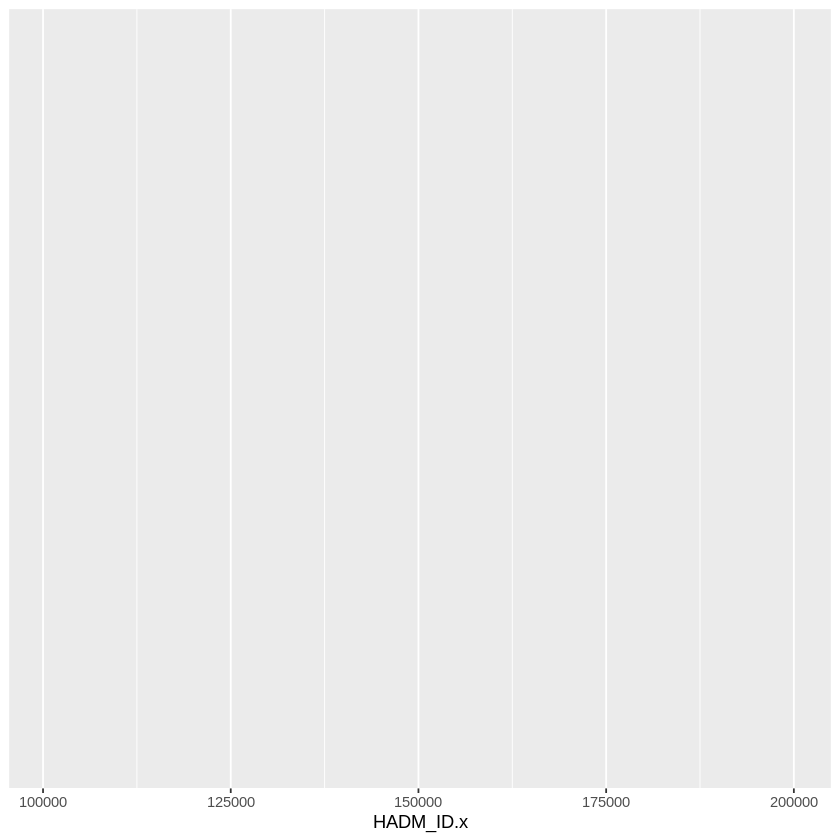

In [140]:
datahisto <- ggplot(data.frame(datatest), aes(x = HADM_ID.x))
datahisto

I am very lost at this part. I do not believe I have been doing this completely correctly up till here. Having prior R experience would have been extremely beneficial I think. From here I skipped ahead to do as much as I could.

-----
##### 2.5 (5 pts)
As you observed from the plot you created above, there are many rare diagnoses, resulting in a sparse feature space. One way to manage this is to identify rare (and similarly, very common) features using *Information content (IC)*. IC is a measure of specificity based on the frequency of occurrence of features.

The IC of a feature that occurs in a set of records is calculated as 

$-log_2 \left( \frac{count(\text{feature})}{count(\text{record})} \right)$

Use this equation to calculate the IC of ICD9 codes based on their occurrence in the diagnosis records for the sepsis cohort.

-----
##### 2.6 (3 pts)

What is the range (min and max) of ICs observed in your data? What are the 10 most specific ICD9 codes?

---

-----
##### 2.7 (2 pts)
Filter the set of ICD9 codes for the diagnoses associated with the set of admissions to those with an IC between 4 and 9.

---

-----
##### 2.8 (12 pts)
Now we have our diagnoses features and the times they occured for each patient. All that is left to do is to create a patient-feature matrix that summarizes and organizes the diagnoses features. In this matrix, each row is an patient and each column in a diagnosis code, time binned by whether or not it occured in the preceeding 6 months prior to the index time. In other words, we are going to generate two features for each diagnosis code where one feature represents the count of the number of times the code was observed in the six months prior to the index time and the other features represents the number of times that code was observed in the medical history older than six months. The way to implement this is using a `mutate` to create a time bin indicator and then grouping on that before summarizing and spreading. Use `unite` before spreading to create a unique name for each feature based on its diagnosis code and time bin.

Note that the ICU stay is the first time many patients have been seen at this hospital, so most patients may have few or no prior recorded diagnoses.

What are the dimensions of your resultant dataframe?

----

### Notes

-----
##### 2.9 (4 pts)
Now let's add features from notes. To do so, we'll have to process some text.

The `noteevents` table in MIMIC is too large and unwieldy to load into R, so we've extracted the rows from that table that you will need. The result is in the file `notes_small_cohort_v2.csv`. Load it into R and examine it with `head()`.

Pay attention to the fact that notes are stored in MIMIC with chartdate information, but that charttime is mostly empty. The way that we will account for this in the context of our cutoff times is by filtering the data such that we only consider notes that were recorded prior to the day corresponding to the cutoff time for each patient. Perform the necessary filtering. How many notes are present before and after the filtering step?

---

----
#### 2.10 (2 pts)
UMLS terminologies provide concept hierarchies, as well as sets of terms for individual concepts. For example, there are more than 50 terms in UMLS terminologies for the concept 'myocardial infarction'!

Soon, you will use the SNOMED CT hierarchy and UMLS term sets to construct a dictionary of terms for inflammatory disorders, and then search for those terms in MIMIC III notes.

First, load `snomed_ct_isaclosure.csv` and `snomed_ct_str_cui.csv` in R, and examine them with `head()`. `snomed_ct_isaclosure.csv` contains the child-parent CUI relationships for all of SNOMED CT. `snomed_ct_str_cui.csv` contains the terms (each with a unique term identifier, tid) for each SNOMED CT CUI.

Join `snomedct_isa_closure` with `snomedct_cui_string` to find all terms for each CUI (including the terms associated with its children).

---

-----
##### 2.11 (6 pts)

One feature that is very likely to impact the likelihood of a patient to develop septic shock is whether they currently have or have a history of inflammatory disorders. Let's extract information from clinical notes to look for the presence of this class of disease.

First, use the CUI for inflammatory disorders in SNOMED CT ("C1290884"), and construct a dictionary of all terms (a set of terms) corresponding to inflammatory disorders that have 20 characters or fewer. How many terms are in the dictionary?

---

-----
##### 2.12 (7 pts)

Using any method you like, use your dictionary to determine if the note text contains each of the first fifty terms in your dictionary (limited for computational purposes). Your answer should have the columns `note_id` (the same as `row_id` in `notes.csv`), `subject_id`, `chartdate`, and as many more columns as there are terms in the dictionary (50).

What are the dimensions of the resulting dataframe?

---

-----
##### 2.13 (6 pts)

Now use your result from question 2.10 to normalize terms back to their concepts and construct a dataframe of `subject_id`, `chartdate` and `concept`.

---

-----
##### 2.14 (7 pts)

As with the diagnoses, we must transform this data into a patient-feature matrix. Use `dplyr` and `tidyr` to transform this table of concept mentions into a patient-feature matrix where each row is a patient and each column is the presence or absence of a concept. Do not do any time-binning. Each concept should have only one column. Instead of counts, use a binary indicator to indicate that the concept was present in the patient's notes prior to the cutoff time.

What are the dimensions of the resulting table?

----

### Vitals

-----
##### 2.15 (2 pts)

Now let's engineer some features from vital sign measurements also relevant to predicting septic shock.

Here we will work with the patient's heart rates. Load the file `vitals_small_cohort.csv` (this file will be familiar to you at this point). Once you have done so, filter measurements so that you are only looking at Heart Rate  measurements that occured prior to the cutoff time for the set of patients in our cohort.

How many patients are left in the dataframe after performing this filtering step?

----

In [168]:
vitals_small_cohort <- read_csv("/content/vitals_small_cohort.csv")

Rows: 599024 Columns: 6

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): vital_id
dbl  (4): subject_id, hadm_id, icustay_id, valuenum
dttm (1): charttime


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [172]:
countdata_filter <- rename(countdata_filter, "hadm_id" = "HADM_ID.x")

In [173]:
vitals_filter <- countdata_filter %>% inner_join(vitals_small_cohort, by = "hadm_id")

In [174]:
head(vitals_filter)

SUBJECT_ID,hadm_id,ADMITTIME,DISCHTIME,time_diff,label,index_time,ICD9_CODE,diagnosis_time,subject_id,icustay_id,charttime,valuenum,vital_id
<dbl>,<dbl>,<dttm>,<dttm>,<drtn>,<chr>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<chr>
67,155252,2157-12-02 00:45:00,2157-12-02 03:55:00,3.166667 hours,Negative,2157-12-02 12:45:00,431,1,67,226216,2157-12-02 01:00:00,86.00000,HeartRate
67,155252,2157-12-02 00:45:00,2157-12-02 03:55:00,3.166667 hours,Negative,2157-12-02 12:45:00,431,1,67,226216,2157-12-02 01:00:00,27.00000,RespRate
67,155252,2157-12-02 00:45:00,2157-12-02 03:55:00,3.166667 hours,Negative,2157-12-02 12:45:00,431,1,67,226216,2157-12-02 01:00:00,189.00000,SysBP
67,155252,2157-12-02 00:45:00,2157-12-02 03:55:00,3.166667 hours,Negative,2157-12-02 12:45:00,431,1,67,226216,2157-12-02 01:00:00,35.83333,TempC
67,155252,2157-12-02 00:45:00,2157-12-02 03:55:00,3.166667 hours,Negative,2157-12-02 12:45:00,431,1,67,226216,2157-12-02 01:15:00,87.00000,HeartRate
67,155252,2157-12-02 00:45:00,2157-12-02 03:55:00,3.166667 hours,Negative,2157-12-02 12:45:00,431,1,67,226216,2157-12-02 01:15:00,28.00000,RespRate


In [177]:
keep3 <- c("SUBJECT_ID", "hadm_id", "ADMITTIME", "index_time", "ICD9_CODE", "charttime", "vital_id")
vitals_filter <- vitals_filter[keep3]
head(vitals_filter)

SUBJECT_ID,hadm_id,ADMITTIME,index_time,ICD9_CODE,charttime,vital_id
<dbl>,<dbl>,<dttm>,<dttm>,<chr>,<dttm>,<chr>
67,155252,2157-12-02 00:45:00,2157-12-02 12:45:00,431,2157-12-02 01:00:00,HeartRate
67,155252,2157-12-02 00:45:00,2157-12-02 12:45:00,431,2157-12-02 01:00:00,RespRate
67,155252,2157-12-02 00:45:00,2157-12-02 12:45:00,431,2157-12-02 01:00:00,SysBP
67,155252,2157-12-02 00:45:00,2157-12-02 12:45:00,431,2157-12-02 01:00:00,TempC
67,155252,2157-12-02 00:45:00,2157-12-02 12:45:00,431,2157-12-02 01:15:00,HeartRate
67,155252,2157-12-02 00:45:00,2157-12-02 12:45:00,431,2157-12-02 01:15:00,RespRate


In [179]:
vitals_filter$hrc <- ifelse(vitals_filter$vital_id=="HeartRate", 1, 0)

In [181]:
vitals_filter_hr_only <- vitals_filter[vitals_filter$hrc != 0,]
head(vitals_filter_hr_only)

SUBJECT_ID,hadm_id,ADMITTIME,index_time,ICD9_CODE,charttime,vital_id,hrc
<dbl>,<dbl>,<dttm>,<dttm>,<chr>,<dttm>,<chr>,<dbl>
67,155252,2157-12-02 00:45:00,2157-12-02 12:45:00,431,2157-12-02 01:00:00,HeartRate,1
67,155252,2157-12-02 00:45:00,2157-12-02 12:45:00,431,2157-12-02 01:15:00,HeartRate,1
67,155252,2157-12-02 00:45:00,2157-12-02 12:45:00,431,2157-12-02 01:30:00,HeartRate,1
67,155252,2157-12-02 00:45:00,2157-12-02 12:45:00,431,2157-12-02 01:40:00,HeartRate,1
67,155252,2157-12-02 00:45:00,2157-12-02 12:45:00,431,2157-12-02 01:45:00,HeartRate,1
67,155252,2157-12-02 00:45:00,2157-12-02 12:45:00,431,2157-12-02 02:00:00,HeartRate,1


In [182]:
vitals_filter_hr_only %>% count(vital_id)

vital_id,n
<chr>,<int>
HeartRate,2892


ANS: After the filtering step there are 2892 patients left in the dataframe.

-----
##### 2.16 (4pts)

One feature of interest might be the latest value of the heart rate before the cutoff time. Use `dplyr` to make a dataframe with three columns: `subject_id`, `latest_heart_rate`, and `charttime`. 

What is the average value of the latest recorded heart rate in this cohort? Additionally, make a histogram or density plot of the latest heart rate colored by whether a patient develops septic shock.

----

In [183]:
vitals_filter_hr_only$latest_heart_rate <- vitals_filter_hr_only$charttime - vitals_filter_hr_only$ADMITTIME

In [184]:
head(vitals_filter_hr_only)

SUBJECT_ID,hadm_id,ADMITTIME,index_time,ICD9_CODE,charttime,vital_id,hrc,latest_heart_rate
<dbl>,<dbl>,<dttm>,<dttm>,<chr>,<dttm>,<chr>,<dbl>,<drtn>
67,155252,2157-12-02 00:45:00,2157-12-02 12:45:00,431,2157-12-02 01:00:00,HeartRate,1,15 mins
67,155252,2157-12-02 00:45:00,2157-12-02 12:45:00,431,2157-12-02 01:15:00,HeartRate,1,30 mins
67,155252,2157-12-02 00:45:00,2157-12-02 12:45:00,431,2157-12-02 01:30:00,HeartRate,1,45 mins
67,155252,2157-12-02 00:45:00,2157-12-02 12:45:00,431,2157-12-02 01:40:00,HeartRate,1,55 mins
67,155252,2157-12-02 00:45:00,2157-12-02 12:45:00,431,2157-12-02 01:45:00,HeartRate,1,60 mins
67,155252,2157-12-02 00:45:00,2157-12-02 12:45:00,431,2157-12-02 02:00:00,HeartRate,1,75 mins


In [186]:
average_last_hr <- vitals_filter_hr_only %>% group_by(latest_heart_rate) %>% summarize(avg_1 = mean(latest_heart_rate))

In [188]:
head(average_last_hr)

latest_heart_rate,avg_1
<drtn>,<drtn>
2 mins,2 mins
7 mins,7 mins
9 mins,9 mins
11 mins,11 mins
15 mins,15 mins
30 mins,30 mins


In [189]:
mean(vitals_filter_hr_only$latest_heart_rate)

Time difference of 427.934 mins

I am not sure that I did this right as it says Time difference of.

-----
##### 2.17 (4 pts)

The latest recorded heart rate might not be a useful feature to use if the latest recording is not near the index time. Make a density plot of the time difference between the latest heart rate recording and the cutoff time colored by whether a patient develops septic shock. Feel free to modify the axes limits if that helps you interpret the plot.

----

-----
##### 2.18 (5 pts)
Some patients might have many heart rate recordings, and only using the last one might not be the best idea- it's possible the latest measurement is an outlier. Let's try to leverage all the heart rate measurements we have by creating a time-weighted average heart rate. Use the formula $w = e^{(-|\Delta t| - 1)}$ to calculate the weights of each measurement, where $\Delta t$ is the time difference between the measurement time and the cutoff time in hours. Calculate the weighted average with the formula $\bar{x}_w = \sum(x_i w_i)/\sum(w_i)$. The result should be a dataframe with two columns: `subject_id` and `time_wt_avg`.

What is the average time-weighted average heart rate across all patients? 

----

-----
##### 2.19 (4 pts)
Let's do a sanity check to see if what we've done makes sense. We expect that the time-weighted average heart rate and the latest recorded heart rate should be similar.

Make a scatterplot of the latest recorded heart rate (x-axis) and the time-weighted average heart rate (y-axis) of each patient.

----

### Stitching together Disease, Text and Vitals Features

-----
##### 2.20 (4 pts)
Our final patient-feature matrix will simply be the amalgamation of the different feature matrices we've created. Use an outer join to combine the columns of the feature matrices from diagnoses, notes, and heart rate measurements. Not all patients have diagnoses or note features, so fill in any NA values with 0 to indicate that there were no diagnoses or notes counted. Similarily, not all subjects have heart rate measurements.  Fill null values for these features with a simple column mean imputation. Use `names` to look at all the features and make sure everything seems ok.


How many total features are there?

----

## 3. Open ended feature engineering - Do something cool! (20 points)

Having made it this far, you have picked up a few generalizable techniques that can now be used to extract features from various modalities of clinical data. To test the skills you've learned thus far, you now have free reign to get creative and derive whatever additional features you would like and use them alongside the disease, text and vitals features as input to a simple classifier. To help you with your task, we provide you with CSV files for ALL of the tables in MIMIC III where each table has been filtered to contain only the records for the patients in our small cohort. These are stored in the folder `additional_data`. To start, we provide you with some baseline code below that runs a logistic regression classifier with a Lasso L1 penalty and reports a cross-validation AUC-ROC.

More concretely, do the following:
* Outside of the features we engineered previously in the assignment, derive additional features that utilize at least five of the additional data tables. You may use tables that we have previously worked with as a part of the assignment, but we encourage you to explore these new data sources. Caveats: definition tables (e.g. d_items) do not count towards the five and using any combination of chartevents tables counts as a single table.
* Combine your derived features into a patient-feature matrix
* Adapt the model-fitting code provided below to your new dataset
* Write 1-2 paragraphs discussing what and how many features you derived. Additionally, discuss the effects of those features on the performance of the classifier.

Feel free to modify anything you would like in the code below to fufill your purposes. That said, you are not being evaluating the performance of your classifier and are instead being evaluated on your feature engineering procedure and discussion, so do not expend too much effort in getting a good AUC-ROC.

In [ ]:
# Baseline implementation - provided

library(caret)

# Requires caret package
# Assumes that feature matrix from 2.22 is stored in X
# Constructs a label vector from label_df - a dataframe containing the septic_shock labels

# Pipeline automatically performs median imputation, centering, scaling, and near-zero-variance feature filtering

# Runs the data through a logistic regression with a lasso penalty
# Reports area under the receiver operating curve as performance metric

baseline_df <- X %>% left_join(select(label_df, subject_id, label)) #%>% mutate()
baseline_features <- baseline_df %>% select(-label, -subject_id) %>% as.data.frame()
labels <- baseline_df %>% select(label) %$% relevel(factor(as.numeric(label), 
                                                                 labels = c('normal', 
                                                                            'septic_shock')), 'septic_shock')
config <- trainControl(method="cv", 
                       number=5, 
                       returnResamp="all",
                       classProbs=TRUE, 
                       summaryFunction=twoClassSummary,
                       verboseIter = TRUE)

baseline_model <- train(baseline_features, 
                             labels, 
                             preProcess = c('medianImpute', 'center', 'scale', 'nzv'),
                             method = "glmnet", 
                             trControl = config,
                             metric = "ROC",
                             tuneGrid = expand.grid(alpha = 1,
                                                    lambda = seq(0.001, 0.1, by = 0.001))
                       )

print(baseline_model$results)

----

### Done!

That's it! You've gone through the major steps of transforming different kinds of data stored in a longitudinal database into a patient-feature matrix that we can use for association tests and prediction tasks. Along the way we hope you have gained practice in how to effectively use the `dplyr` and `tidyr` packages to manipulate data and the `ggplot2` package to make visual diagnostics. You are well on your way to being able to perform a clinical informatics study.

## Feedback (0 points)
####  How much time did you spend on this assignment?

####  How much did you learn? Choose one (type your answer after the table):
   A | B | C | D | E |
   --|---|---|---|---|
   a great deal |  a lot  |  a moderate amount | a little | none at all|

#### Did you do any of the following: go to office hours, post on canvas, e-mail TAs? If so, which?

